## Problem Statement:

‘Znailla Bank’, a subsidiary within the ‘Znailla Group’, which is a multinational insurance group
with a presence in the banking industry, offers a term deposit product.

In the last 2 years, ‘Znailla Bank’ has invested massively in reaching out to its portfolio of existing
customers - those with already a current account- to offer the product through a call center
campaign. In fact, ‘Znailla Bank’ has been running a process which selects a subset of their
customer portfolio every week, and the list of those customers is sent to the call center to be
actioned.

The campaign has a positive impact, but given the significant cost of the call (~8€) and Znailla's
commitment to process optimization, the management has decided to investigate how to use
Analytics to help us to improve the costs-efficiency of the process.

The head of Marketing has asked whether it would be possible to reduce the number of calls by
predicting the "wasted calls" (calls to non-converting customers). Specifically, he asks how many
calls can be saved, given that he wants to lose as little business as possible.

As the data scientist responsible for this project, your role is to build a Machine Learning pipeline
to identify customers that should be called within the weekly cohort and provide
recommendations on how to reduce the number of calls.

In [107]:
# import necessary packages

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [5]:
# read data from .csv

data = pd.read_csv('../data/bank-additional-full.csv',delimiter=';')

data.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [88]:
data.shape

(41188, 21)

### Missing values analysis:

In [40]:
# null values from data

data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [28]:
print('Total number of entries in dataset :',data.shape[0])

Total number of entries in dataset : 41188


In [6]:
# get column names

list(data.columns)

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [7]:
print('Total number of features :',len(list(data.columns)))

Total number of features : 21


In [15]:
# get categorical columns

cat_columns = data.select_dtypes(include=['object']).columns.tolist()
cat_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [30]:
# get stats for categorical columns

data.select_dtypes(include=['object']).describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [35]:
# create function to plot categories

def plot_count(feature,data_frame):

    # plot countplot of body_type and add count on each bar
    plt.figure(figsize=(8,8))
    sns.countplot(y=feature,data=data_frame)
    plt.title(f'Count of categories in {feature}')
    for p in plt.gca().patches:
        plt.gca().annotate('{:.0f}'.format(p.get_width()), (p.get_width(), p.get_y()+p.get_height()/2.), ha='center', va='center', xytext=(10, 0), textcoords='offset points')
    plt.show()

Feature Name : job
____________________________________________________________________________________________________


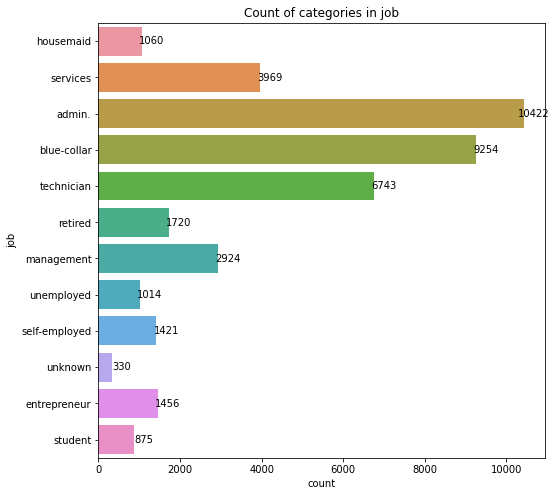

****************************************************************************************************
Feature Name : marital
____________________________________________________________________________________________________


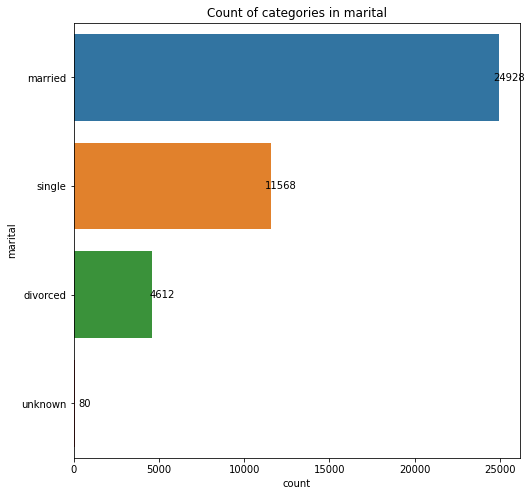

****************************************************************************************************
Feature Name : education
____________________________________________________________________________________________________


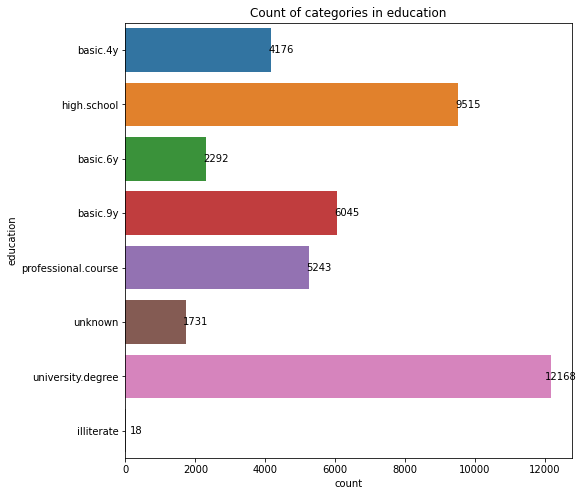

****************************************************************************************************
Feature Name : default
____________________________________________________________________________________________________


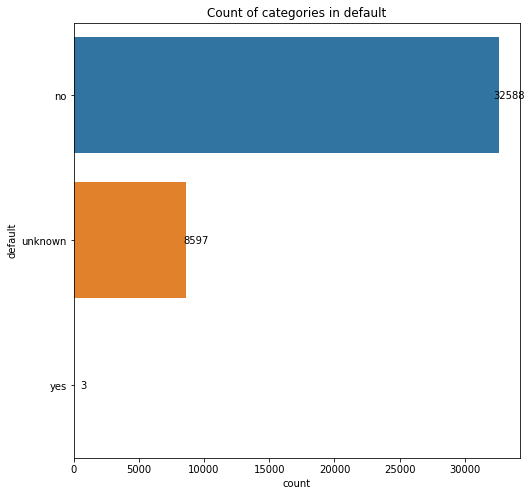

****************************************************************************************************
Feature Name : housing
____________________________________________________________________________________________________


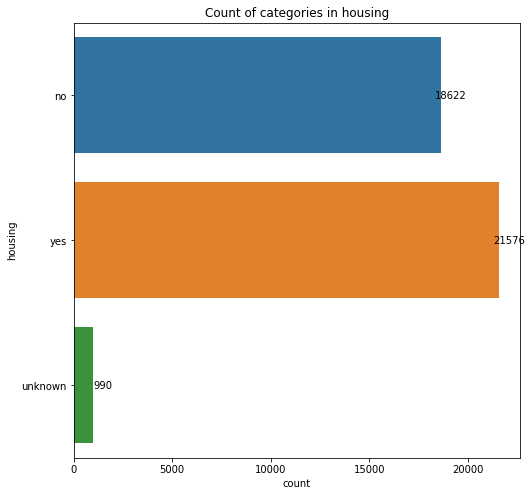

****************************************************************************************************
Feature Name : loan
____________________________________________________________________________________________________


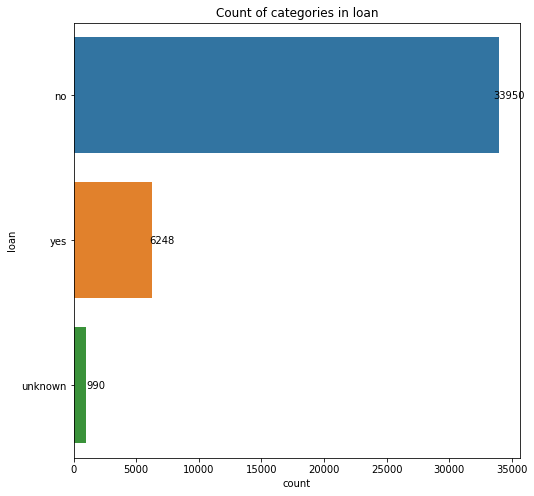

****************************************************************************************************
Feature Name : contact
____________________________________________________________________________________________________


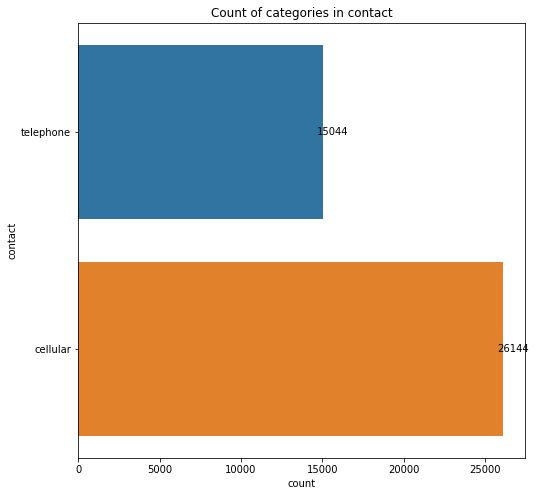

****************************************************************************************************
Feature Name : month
____________________________________________________________________________________________________


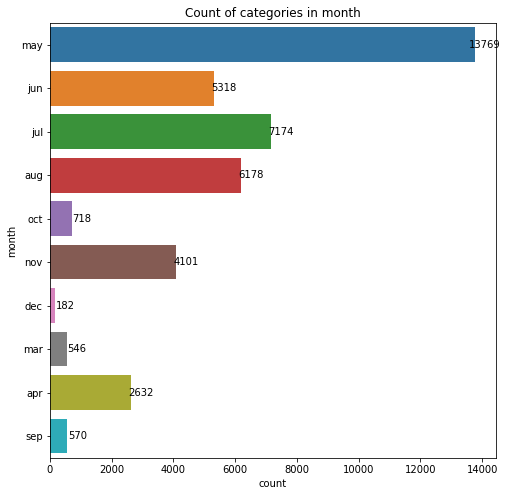

****************************************************************************************************
Feature Name : day_of_week
____________________________________________________________________________________________________


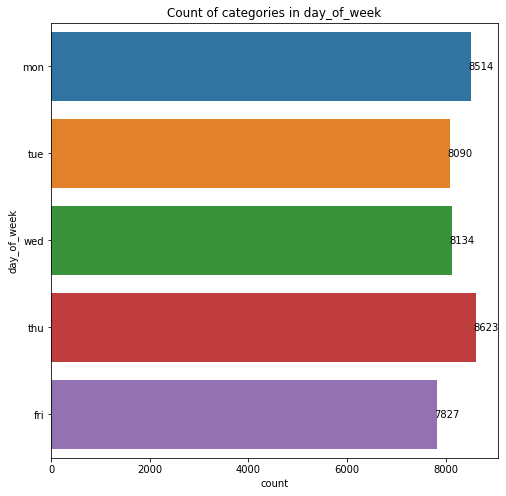

****************************************************************************************************
Feature Name : poutcome
____________________________________________________________________________________________________


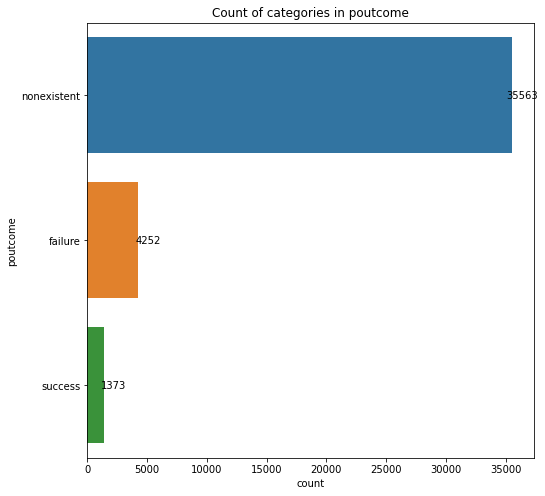

****************************************************************************************************
Feature Name : y
____________________________________________________________________________________________________


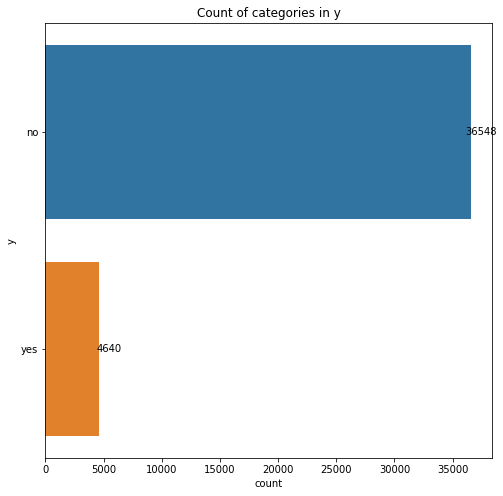

****************************************************************************************************


In [39]:
for cat in cat_columns:
    print('Feature Name :',cat)
    print('_'*100)
    plot_count(cat,data)
    print('*'*100)

In [14]:
# get numerical columns

num_columns = data.select_dtypes(exclude=['object']).columns.tolist()

num_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [31]:
# get stats for numerical columns

data.select_dtypes(exclude=['object']).describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Age:

In [18]:
# fetaure wise analysis

print('Uniqque values for age is:',data.age.nunique())

Uniqque values for age is: 78


In [24]:
# getting value counts for 

data.age.value_counts()[-10:]

86    8
84    7
17    5
92    4
89    2
91    2
98    2
87    1
94    1
95    1
Name: age, dtype: int64

In [25]:
# get idea about distribution of age

for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(data['age'], i)))

10 Quantile is 28.0
20 Quantile is 31.0
30 Quantile is 33.0
40 Quantile is 35.0
50 Quantile is 38.0
60 Quantile is 41.0
70 Quantile is 45.0
80 Quantile is 49.0
90 Quantile is 55.0
100 Quantile is 98.0


In [27]:
# get idea about distribution of age

for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(data['age'], i)))

90 Quantile is 55.0
91 Quantile is 55.0
92 Quantile is 56.0
93 Quantile is 56.0
94 Quantile is 57.0
95 Quantile is 58.0
96 Quantile is 59.0
97 Quantile is 59.0
98 Quantile is 62.0
99 Quantile is 71.0
100 Quantile is 98.0


### Observation:

- 98 percentile values are upto 62 age.

### Outlier analysis using boxplot:

Feature Name : age
____________________________________________________________________________________________________


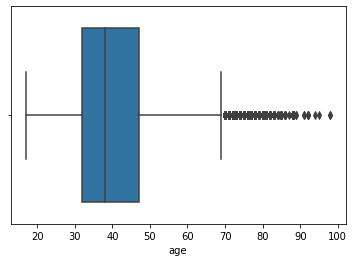

****************************************************************************************************
Feature Name : duration
____________________________________________________________________________________________________


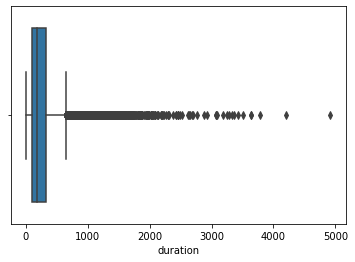

****************************************************************************************************
Feature Name : campaign
____________________________________________________________________________________________________


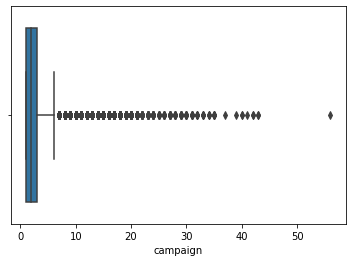

****************************************************************************************************
Feature Name : pdays
____________________________________________________________________________________________________


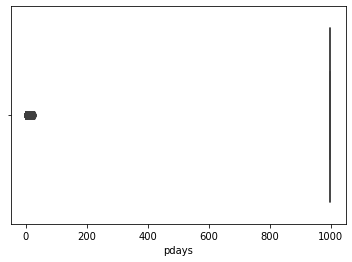

****************************************************************************************************
Feature Name : previous
____________________________________________________________________________________________________


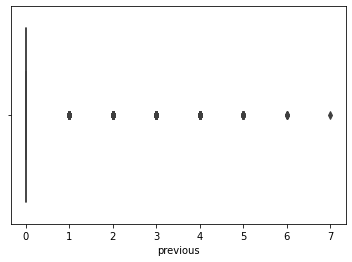

****************************************************************************************************
Feature Name : emp.var.rate
____________________________________________________________________________________________________


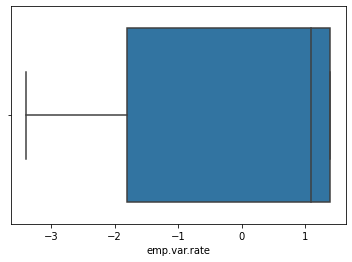

****************************************************************************************************
Feature Name : cons.price.idx
____________________________________________________________________________________________________


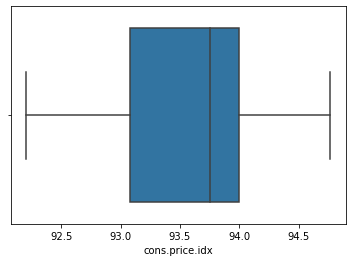

****************************************************************************************************
Feature Name : cons.conf.idx
____________________________________________________________________________________________________


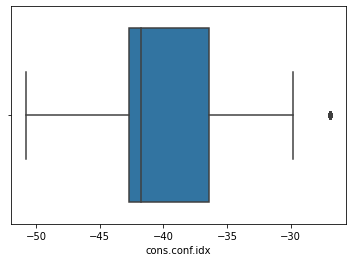

****************************************************************************************************
Feature Name : euribor3m
____________________________________________________________________________________________________


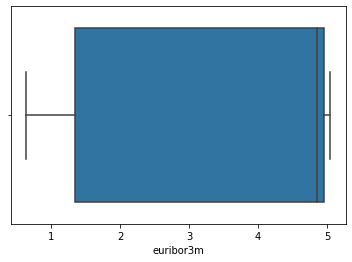

****************************************************************************************************
Feature Name : nr.employed
____________________________________________________________________________________________________


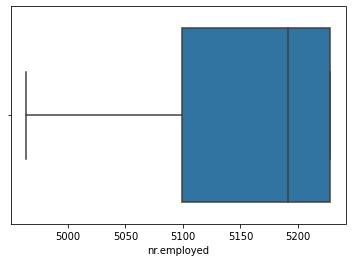

****************************************************************************************************


In [42]:
for cat in num_columns:
    print('Feature Name :',cat)
    print('_'*100)
    sns.boxplot(x=data[cat])
    plt.show()
    print('*'*100)

In [53]:
def remove_outliers(dataframe,cat):

    # Computing 10th, 90th percentiles and replacing the outliers 
    tenth_percentile = np.percentile(dataframe[cat],10) 
    ninetieth_percentile = np.percentile(dataframe[cat], 90) 
    # print(tenth_percentile, ninetieth_percentile)b = 
    dataframe[cat] = np.where(dataframe[cat]<tenth_percentile, tenth_percentile, dataframe[cat]) 
    dataframe[cat] = np.where(dataframe[cat]>ninetieth_percentile, ninetieth_percentile, dataframe[cat]) 
    # print("Sample:", sample) 
    
    return tenth_percentile,ninetieth_percentile
    
    

In [73]:
# remove outliers

percentile_dict = {}
final_data = data.copy()
for cat in num_columns:
    
    tenth_percentile,ninetieth_percentile = remove_outliers(final_data,cat)
    
    percentile_dict.update({cat:(tenth_percentile,ninetieth_percentile)})
    
    

In [74]:
percentile_dict

{'age': (28.0, 55.0),
 'duration': (59.0, 551.0),
 'campaign': (1.0, 5.0),
 'pdays': (999.0, 999.0),
 'previous': (0.0, 1.0),
 'emp.var.rate': (-1.8, 1.4),
 'cons.price.idx': (92.893, 94.465),
 'cons.conf.idx': (-46.2, -36.1),
 'euribor3m': (1.046, 4.964),
 'nr.employed': (5076.2, 5228.1)}

Feature Name : age
____________________________________________________________________________________________________


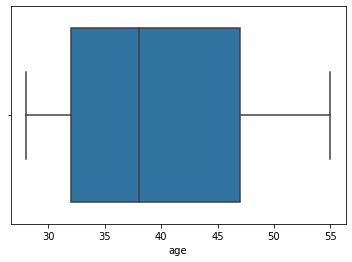

****************************************************************************************************
Feature Name : duration
____________________________________________________________________________________________________


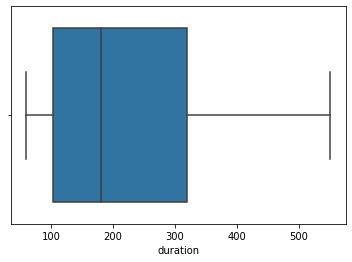

****************************************************************************************************
Feature Name : campaign
____________________________________________________________________________________________________


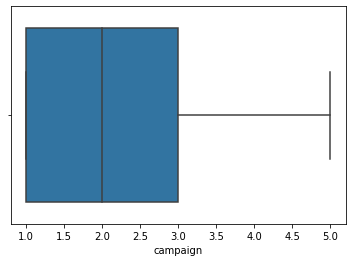

****************************************************************************************************
Feature Name : pdays
____________________________________________________________________________________________________


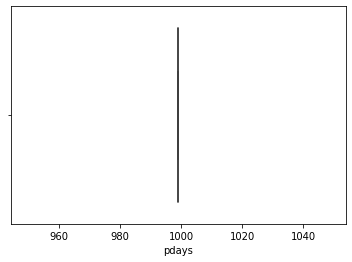

****************************************************************************************************
Feature Name : previous
____________________________________________________________________________________________________


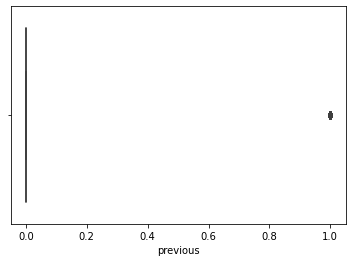

****************************************************************************************************
Feature Name : emp.var.rate
____________________________________________________________________________________________________


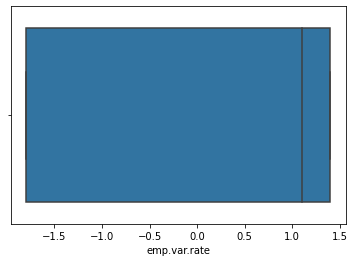

****************************************************************************************************
Feature Name : cons.price.idx
____________________________________________________________________________________________________


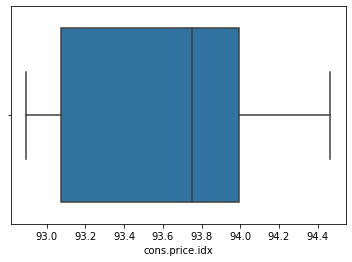

****************************************************************************************************
Feature Name : cons.conf.idx
____________________________________________________________________________________________________


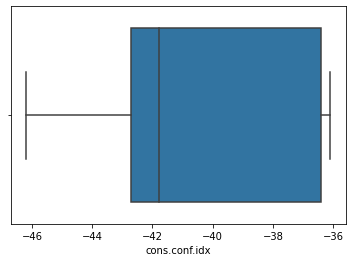

****************************************************************************************************
Feature Name : euribor3m
____________________________________________________________________________________________________


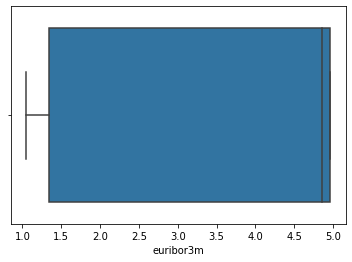

****************************************************************************************************
Feature Name : nr.employed
____________________________________________________________________________________________________


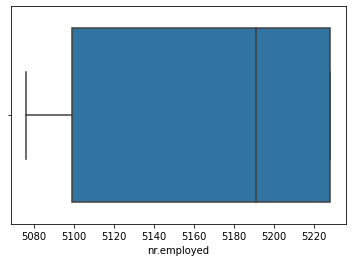

****************************************************************************************************


In [75]:
for cat in num_columns:
    print('Feature Name :',cat)
    print('_'*100)
    sns.boxplot(x=final_data[cat])
    plt.show()
    print('*'*100)

### Data Preprocessing:

In [76]:
# get class label and features

y = final_data.y

x = final_data.drop(columns =['y'],axis =1)

In [119]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [93]:
# pip install category_encoders

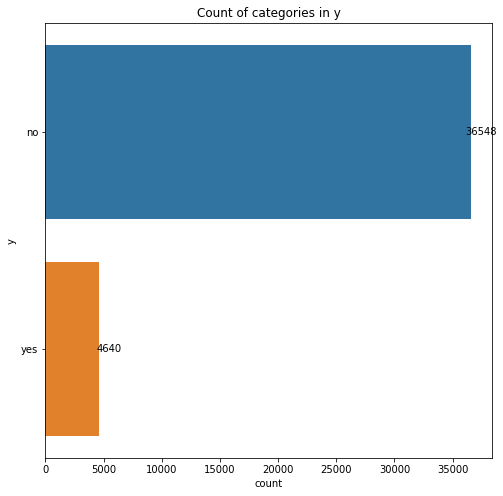

In [94]:
# check imbalanceness

plot_count('y',data)

In [95]:
cat_cols =['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [120]:
import category_encoders as ce


#Create object for one-hot encoding
encoder=ce.OneHotEncoder(cols=cat_cols,handle_unknown='return_nan',return_df=True,use_cat_names=True)

encoder.fit(X_train)
X_train = encoder.transform(X_train)
x_test = encoder.transform(X_test)
X_train.shape

(32950, 63)

In [121]:
X_train.columns

Index(['age', 'job_blue-collar', 'job_admin.', 'job_retired', 'job_housemaid',
       'job_management', 'job_technician', 'job_entrepreneur', 'job_services',
       'job_student', 'job_unemployed', 'job_self-employed', 'job_unknown',
       'marital_married', 'marital_divorced', 'marital_single',
       'marital_unknown', 'education_basic.9y', 'education_university.degree',
       'education_basic.4y', 'education_high.school',
       'education_professional.course', 'education_basic.6y',
       'education_unknown', 'education_illiterate', 'default_unknown',
       'default_no', 'default_yes', 'housing_yes', 'housing_no',
       'housing_unknown', 'loan_no', 'loan_yes', 'loan_unknown',
       'contact_telephone', 'contact_cellular', 'month_jul', 'month_may',
       'month_apr', 'month_nov', 'month_jun', 'month_mar', 'month_aug',
       'month_sep', 'month_oct', 'month_dec', 'day_of_week_mon',
       'day_of_week_tue', 'day_of_week_thu', 'day_of_week_fri',
       'day_of_week_wed', 'dura

In [122]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(X_train, y_train)

In [123]:
x_train.shape

(58490, 63)

In [124]:
y_train.value_counts()

yes    29245
no     29245
Name: y, dtype: int64

## Approach 1 : 
- Using bag of words as vectorizer.
- Try different algorithms using gridsearch.

#### Logistic_regression :

In [116]:
# Define the logistic regression model
scoring = ['precision_macro', 'recall_macro', 'balanced_accuracy']

logreg = LogisticRegression()

# Define hyperparameters and their possible values for grid search
param_grid = {
    'penalty': ['l1', 'l2'],            # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Create GridSearchCV instance
grid_search = GridSearchCV(logreg, param_grid, cv=3, scoring=scoring,refit='precision_macro')

# Fit the model with the training data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             refit='precision_macro',
             scoring=['precision_macro', 'recall_macro', 'balanced_accuracy'])

In [125]:
# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validated Accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the model on the test set
test_accuracy = grid_search.score(x_test, y_test)
print("Test Set Accuracy: {:.2f}".format(test_accuracy))

Best Parameters:  {'C': 0.001, 'penalty': 'l2'}
Best Cross-Validated Accuracy: 0.87
Test Set Accuracy: 0.69


In [126]:
log_model = LogisticRegression(C = 0.01, penalty='l2')

log_model.fit(x_train, y_train)

LogisticRegression(C=0.01)

In [128]:
y_pred = log_model.predict(x_test)

print(classification_report(y_test, y_pred, target_names = final_data['y'].unique()))

              precision    recall  f1-score   support

          no       0.99      0.82      0.90      7303
         yes       0.40      0.91      0.55       935

    accuracy                           0.83      8238
   macro avg       0.69      0.87      0.72      8238
weighted avg       0.92      0.83      0.86      8238



In [130]:
# save logistic regression model
import pickle

with open('../model/log_model_final.pkl', 'wb') as log_model_file:
    pickle.dump(log_model, log_model_file)

#### DecisionTreeClassifier:

In [133]:
# Define the logistic regression model
scoring = ['precision_macro', 'recall_macro', 'balanced_accuracy']

d_tree = DecisionTreeClassifier()

# Define hyperparameters and their possible values for grid search
param_grid = {'min_samples_split':[5, 10, 100, 500],'max_depth': [1, 3, 10, 30]}

# Create GridSearchCV instance
grid_search_d_tree = GridSearchCV(d_tree, param_grid, cv=3, scoring=scoring,refit='precision_macro',n_jobs = -1)

# Fit the model with the training data
grid_search_d_tree.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             refit='precision_macro',
             scoring=['precision_macro', 'recall_macro', 'balanced_accuracy'])

In [134]:
# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search_d_tree.best_params_)
print("Best Cross-Validated Accuracy: {:.2f}".format(grid_search_d_tree.best_score_))

# Evaluate the model on the test set
test_accuracy = grid_search_d_tree.score(x_test, y_test)
print("Test Set Accuracy: {:.2f}".format(test_accuracy))

Best Parameters:  {'max_depth': 30, 'min_samples_split': 10}
Best Cross-Validated Accuracy: 0.93
Test Set Accuracy: 0.72


In [135]:
d_tree_model = DecisionTreeClassifier(max_depth = 30, min_samples_split = 500,class_weight='balanced')

d_tree_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=500)

In [137]:
y_pred = d_tree_model.predict(x_test)

print(classification_report(y_test, y_pred, target_names = final_data['y'].unique()))

              precision    recall  f1-score   support

          no       0.97      0.88      0.92      7303
         yes       0.45      0.75      0.56       935

    accuracy                           0.87      8238
   macro avg       0.71      0.82      0.74      8238
weighted avg       0.91      0.87      0.88      8238



#### SGDClassifier:

In [138]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier()
sgdc.fit(x_train, y_train) 

SGDClassifier()

In [140]:
y_pred = sgdc.predict(x_test)

print(classification_report(y_test, y_pred, target_names = final_data['y'].unique()))

              precision    recall  f1-score   support

          no       0.90      0.99      0.94      7303
         yes       0.66      0.12      0.20       935

    accuracy                           0.89      8238
   macro avg       0.78      0.55      0.57      8238
weighted avg       0.87      0.89      0.86      8238



#### Random_forest :

In [141]:
# train random forest model

rf_classifier = RandomForestClassifier(n_estimators=50,max_depth =30,min_samples_split=500,min_samples_leaf =2,random_state=42)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=500,
                       n_estimators=50, random_state=42)

In [143]:
y_pred = rf_classifier.predict(x_test)

print(classification_report(y_test, y_pred, target_names = final_data['y'].unique()))

              precision    recall  f1-score   support

          no       0.96      0.90      0.93      7303
         yes       0.48      0.74      0.59       935

    accuracy                           0.88      8238
   macro avg       0.72      0.82      0.76      8238
weighted avg       0.91      0.88      0.89      8238



#### XGBoost:

In [144]:
# train xg_boost classifier

xg_boost_clf = xgb.XGBClassifier(learning_rate= 0.03657139351797285, max_depth= 8, n_estimators= 166, subsample= 0.8123333422115437)

xg_boost_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03657139351797285, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=166, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8123333422115437, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [147]:
y_pred = xg_boost_clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names = final_data['y'].unique()))

              precision    recall  f1-score   support

          no       0.95      0.95      0.95      7303
         yes       0.59      0.57      0.58       935

    accuracy                           0.91      8238
   macro avg       0.77      0.76      0.76      8238
weighted avg       0.91      0.91      0.91      8238



### Time Inference with two best models:

#### Random Forest:

In [149]:
import time

# Measure the time required for predictions
start_time = time.time()
predictions = rf_classifier.predict(x_test)
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time
print(f"Time taken for predictions: {time_taken:.6f} seconds")

Time taken for predictions: 0.052453 seconds


#### XGBoost:

In [151]:


# Measure the time required for predictions
start_time = time.time()
predictions = xg_boost_clf.predict(x_test)
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time
print(f"Time taken for predictions: {time_taken:.6f} seconds")

Time taken for predictions: 0.037210 seconds


### Conclusion:

In [148]:
# tabulate results
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Weighted avg F-score"]
x.add_rows(
    [
        ['Logistic Regression','0.86'],
        ['DecisionTreeClassifier','0.88'],
        ['SGDClassifier','0.86'],
        ['RandomForestClassifier','0.89'],
        ['XGBClassifier','0.91'],
    ]
)

print(x)

+------------------------+----------------------+
|         Model          | Weighted avg F-score |
+------------------------+----------------------+
|  Logistic Regression   |         0.86         |
| DecisionTreeClassifier |         0.88         |
|     SGDClassifier      |         0.86         |
| RandomForestClassifier |         0.89         |
|     XGBClassifier      |         0.91         |
+------------------------+----------------------+


In [152]:
t = PrettyTable()

t.field_names = ["Model","Time-taken(Seconds)"]
t.add_rows(
    [
        ['Logistic Regression','0.052453 seconds'],
        ['XGBoost', '0.037210 seconds']

    ]
)

print(t)

+---------------------+---------------------+
|        Model        | Time-taken(Seconds) |
+---------------------+---------------------+
| Logistic Regression |   0.052453 seconds  |
|       XGBoost       |   0.037210 seconds  |
+---------------------+---------------------+


### Experiments :

    - We have carried out multiple experiments with differente models such as Logistic regression,Random Forest, XG Boost.
    - Also for hyperparameter tuning we have tried GridsearchCV.
    
### Observations:


    - Amongst all algorithm we tried Random forest and Xgboost perform well.
    - If we consider both Fscore as well as time inference we can go ahead with XGboost model.
    
